# Определение жанра по изображению обложки музыкального диска.

**Постановка задачи:**

Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

**Данные:**

- Изображения в формате PNG (7800 изображений), упакованные в zip-архив.

- Имя архива соответствует музыкальному жанру (10 папок).

**Метрики:**

Accuracy, Precision, Recall, F1

### Импорт библиотек и инструментов для работы.

In [1]:
import numpy as np
import pandas as pd
import random, os
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

from fastai.vision.all import *
from tensorflow.keras import backend as K
from glob import glob
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

2024-04-30 05:18:10.941947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 05:18:10.942056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 05:18:11.074176: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


***1.Ознакомление с данными.***

In [2]:
files_list = []
for root, dirs, files in os.walk("/kaggle/input/cover-genre", topdown=False):
    for name in files:
        if name.endswith(".png"):
            file_path = os.path.join(root, name)
            genre_name = os.path.basename(root)
            file_size = os.path.getsize(file_path)
            file_info = {'file_name': name, 'genre_name': genre_name, 'file_size': file_size}
            files_list.append(file_info)

In [3]:
df = pd.DataFrame(files_list)

In [4]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Пропуски', 'Процент'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [5]:
%%time
missing_data(df)

CPU times: user 9.48 ms, sys: 894 µs, total: 10.4 ms
Wall time: 14.9 ms


file_name genre_name file_size
Пропуски         0          0         0
Процент        0.0        0.0       0.0
Types       object     object     int64

In [6]:
def describe_df(df):
    display(df.head())
    print('-----------------------------------------------------------------------------------------------')
    display(df.info())
    print('-----------------------------------------------------------------------------------------------')
    display(df.describe())
    print('-----------------------------------------------------------------------------------------------')
    display(df.isna().sum())
    print('-----------------------------------------------------------------------------------------------')
    display(f'Number of duplicates: {df.duplicated().sum()}')

In [7]:
describe_df(df)

file_name genre_name  file_size
0  7653e2aa-9f6f-4c60-ab32-36ca3bf5031b.png      disco     189610
1  ebcf0cc4-995c-4f63-a326-d4a340e73a58.png      disco     164445
2  a24fbdb4-358b-483c-818f-ba40230c8194.png      disco     180134
3  0afb79bf-2181-44a5-99dc-b7ae74a90b93.png      disco     174815
4  0e246594-f674-4872-a628-f52e7200aec9.png      disco     162923

-----------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   7800 non-null   object
 1   genre_name  7800 non-null   object
 2   file_size   7800 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 182.9+ KB


None

-----------------------------------------------------------------------------------------------


file_size
count    7800.000000
mean   161171.728205
std     40393.251247
min     15792.000000
25%    134670.500000
50%    164310.000000
75%    189490.000000
max    284731.000000

-----------------------------------------------------------------------------------------------


file_name     0
genre_name    0
file_size     0
dtype: int64

-----------------------------------------------------------------------------------------------


'Number of duplicates: 0'

In [8]:
df = df.sample(frac=1).reset_index(drop = True)
df.head(10)

file_name   genre_name  file_size
0  4e84b6a3-9fe7-4c8a-abfa-fd343bc0bdf9.png          pop     226152
1  ebad9a2c-aafc-46e7-ab47-3e9f04f0631b.png          edm     214825
2  2d2e5a13-c894-42df-a12e-bde26d43084a.png        disco     181331
3  ee9fbaed-a6e2-42d0-912d-12fc8191cc98.png  black metal     192007
4  6168b195-b2bc-49be-b45d-067d4cd46314.png      country     118186
5  71d7f221-d7fa-4c3e-84c6-81d7b5db6bf3.png        anime     159761
6  18468605-5e58-4b8b-827a-c051a9f893d5.png      country     168582
7  34a092d5-d2e3-3d2a-9777-daba603df345.png  black metal      95132
8  90c40569-5bc4-4577-8609-2934f5eb1b9d.png          pop     221525
9  7c15f8a2-7c8a-4c4d-98c1-cf9dc5d427e6.png        anime     163008

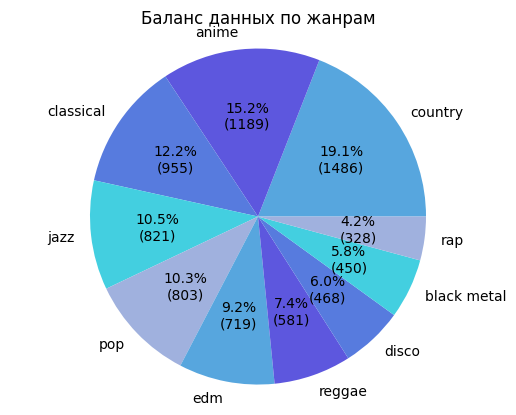

In [9]:
data_balance = df['genre_name'].value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#57A6DE","#5D57DE","#577BDE","#43CFE0","#A0B1DE"])
plt.title("Баланс данных по жанрам")
plt.axis("equal")
plt.show()

In [10]:
df.shape

(7800, 3)

<Axes: xlabel='genre_name', ylabel='count'>

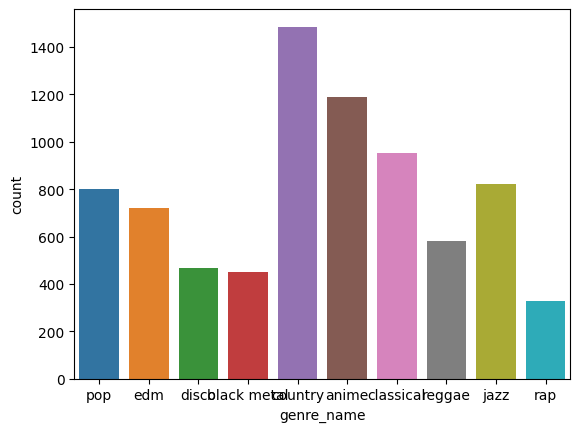

In [11]:
sns.countplot(data= df, x="genre_name")

In [12]:
print("Повторяющиеся названия изображений:")
df[df.duplicated(subset=['file_name'], keep=False)]

Повторяющиеся названия изображений:


file_name genre_name  file_size
1923  9123d325-bf8e-4423-be98-98478dccee20.png        rap     175917
2408  6ea3d2de-f234-4bdd-8ba8-4e9523f5ae1a.png      disco     148802
2954  7e5955d3-c4f3-493c-a3d4-8b855bfc1833.png        pop     153558
3875  9123d325-bf8e-4423-be98-98478dccee20.png        pop     175917
4269  6ea3d2de-f234-4bdd-8ba8-4e9523f5ae1a.png        pop     148802
4903  5c4f2c7c-8412-39fa-9468-23c52e285cd7.png      disco     150029
6384  5c4f2c7c-8412-39fa-9468-23c52e285cd7.png     reggae     150029
6585  7e5955d3-c4f3-493c-a3d4-8b855bfc1833.png        rap     153558

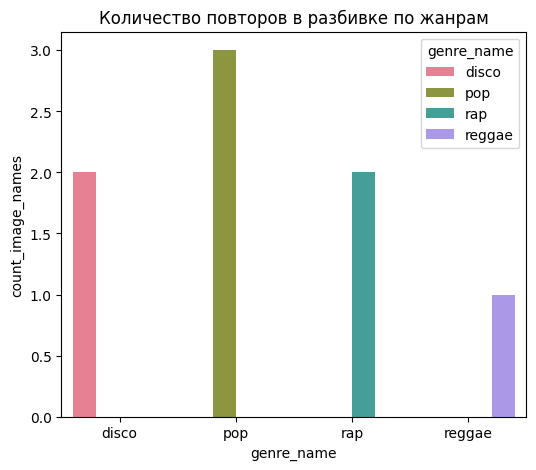

In [13]:
plt.figure(figsize=(6, 5))
df_agg = df[df.duplicated(subset=['file_name'], keep=False)].groupby('genre_name').agg({'file_name': 'count'}).reset_index()
df_agg.rename(columns={'file_name': 'count_image_names'}, inplace=True)
sns.barplot(data=df_agg,
            x='genre_name',
            y='count_image_names',
            hue='genre_name',
            palette=sns.color_palette("husl", len(df_agg)))

plt.title(f"Количество повторов в разбивке по жанрам")
plt.show()

#### Вывод:

- наименьшее количество изображений обложек в жанре rap, больше жанр country;

- нет полных повторов строк;

- количество повторов названий изображений: 4, их анализ показал, что альбомы с этими изображаениями относятся к различным музыкальным жанрам;

- жанр, пересечений альбомов с другими жанрами - pop.

***2.Создание baseline-модели.***

In [14]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [15]:
train_df.shape

(6240, 3)

In [16]:
image_dir = Path("/kaggle/input/cover-genre")
filepaths=list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')
image_df = pd.concat([filepaths, labels], axis=1)

In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [18]:
train_df, ts_df = train_test_split(image_df, train_size = 0.8, shuffle = True, random_state = 12345)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 12345)

In [19]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4992 validated image filenames belonging to 10 classes.
Found 1248 validated image filenames belonging to 10 classes.
Found 780 validated image filenames belonging to 10 classes.


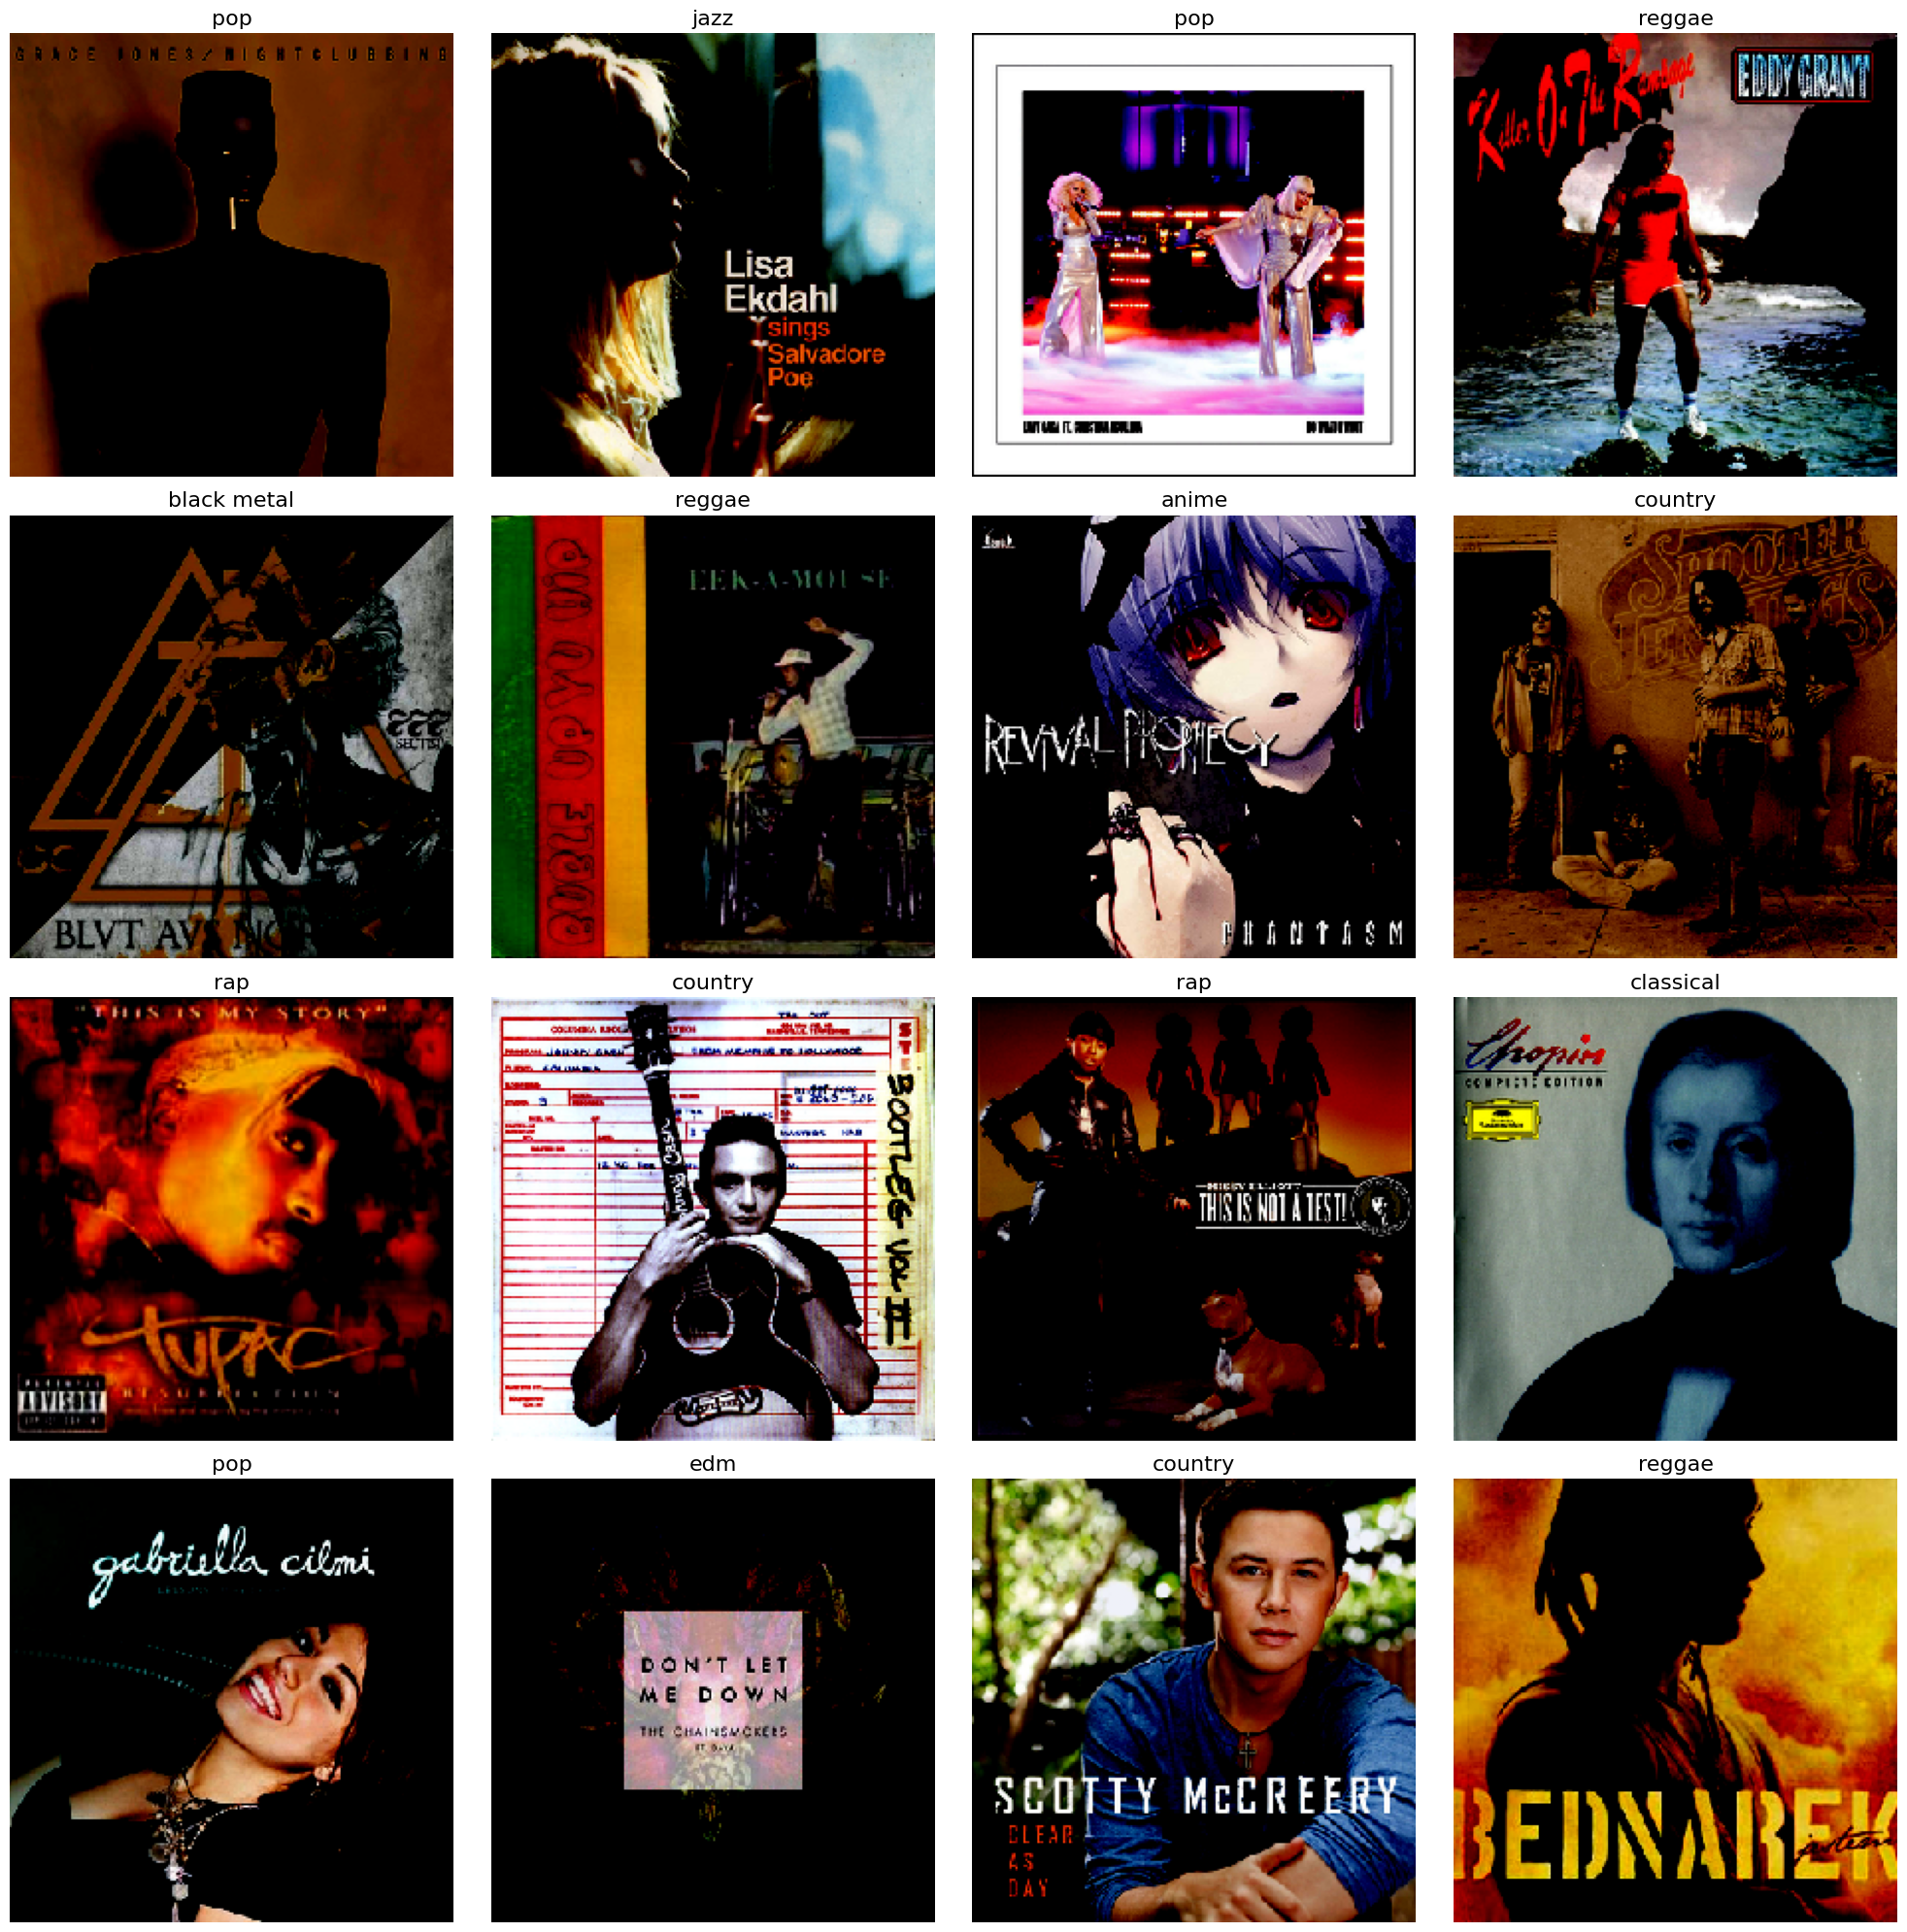

In [20]:
batch_size=16
g_dict = train_images.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_images)      

plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Вывод:

- разбили данные на обучаемые, валидационные и тестовые (80/10/10 % от данных);

- использовали генератор данных изображений;

- подготовили данные для обучения и посмотрели на 16 изображений.

***3.Расчет метрик.***

In [21]:
def create_model(input_shape=(224, 224, 3)):

    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)

    x = base_model(inputs)

    x = GlobalAveragePooling2D()(x)

    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)

    outputs = Dense(10, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    return model
K.clear_session()

model = create_model((224, 224, 3))

metrics = ['accuracy','AUC']

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [23]:
checkpoint_path = 'models/EfficientNetB1/model_224.keras'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [24]:
%%time
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1714453341.592639     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - AUC: 0.7728 - accuracy: 0.4088 - loss: 1.7233
Epoch 1: val_loss improved from inf to 2.65089, saving model to models/EfficientNetB1/model_224.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 230s 556ms/step - AUC: 0.7731 - accuracy: 0.4093 - loss: 1.7221 - val_AUC: 0.5401 - val_accuracy: 0.1146 - val_loss: 2.6509 - learning_rate: 0.0010
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - AUC: 0.9107 - accuracy: 0.6472 - loss: 1.0342
Epoch 2: val_loss did not improve from 2.65089
156/156 ━━━━━━━━━━━━━━━━━━━━ 46s 285ms/step - AUC: 0.9107 - accuracy: 0.6472 - loss: 1.0342 - val_AUC: 0.5998 - val_accuracy: 0.0986 - val_loss: 5.3146 - learning_rate: 0.0010
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - AUC: 0.9464 - accuracy: 0.7615 - loss: 0.7146
Epoch 3: val_loss improved from 2.65089 to 1.73810, saving model to models/EfficientNetB1/model_224.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 280ms/step - AUC: 0.9464 - accuracy: 0.7614 - loss: 0.7148 - val

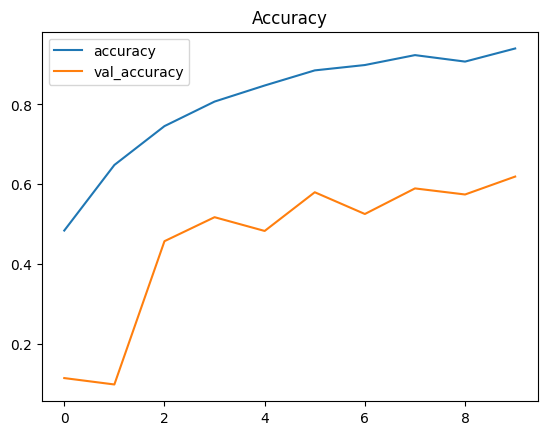

In [25]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

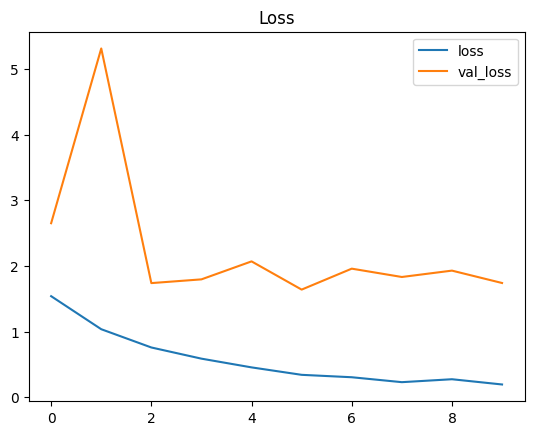

In [26]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [27]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.74080
Test Accuracy: 63.21%


In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step
The first 10 predictions: ['black metal', 'reggae', 'rap', 'reggae', 'jazz', 'jazz', 'anime', 'anime', 'anime', 'country']


In [29]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       anime       0.79      0.79      0.79       108
 black metal       0.97      0.78      0.87        50
   classical       0.80      0.95      0.87       113
     country       0.58      0.56      0.57       124
       disco       0.32      0.50      0.39        42
         edm       0.51      0.61      0.56        69
        jazz       0.57      0.42      0.48        98
         pop       0.52      0.36      0.42        81
         rap       0.68      0.46      0.55        28
      reggae       0.54      0.70      0.61        67

    accuracy                           0.63       780
   macro avg       0.63      0.61      0.61       780
weighted avg       0.64      0.63      0.63       780



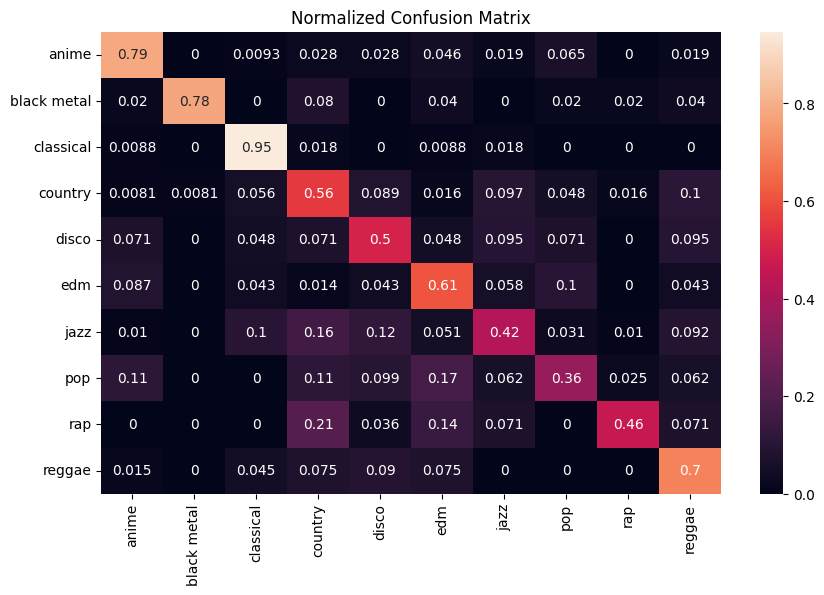

In [30]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

Посмотрим на 15 изображений набора данных с их результатами: True/Predicted

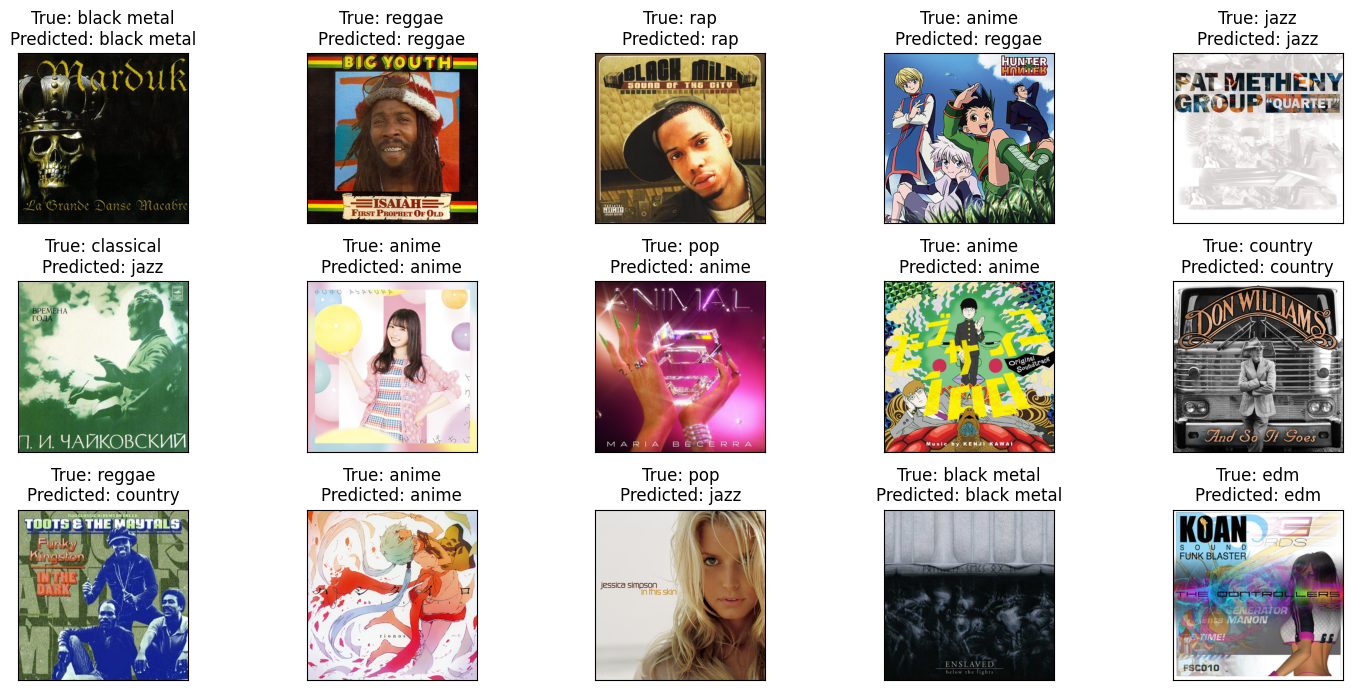

In [31]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

### Вывод:

- использовал обученную в качестве базовой модели EfficientNetB1;

- получили accuracy 0.63;

- обучение проводил на 10 эпохах, на графиках видно изменение результата и результат оптимальный на 6 эпохи;

- выведен результат 15 изображений.

***4.Подготовка данных для нейронной сети.***

In [2]:
path = Path('/kaggle/input/cover-genre'); path.ls()

(#10) [Path('/kaggle/input/cover-genre/disco'),Path('/kaggle/input/cover-genre/rap'),Path('/kaggle/input/cover-genre/black metal'),Path('/kaggle/input/cover-genre/reggae'),Path('/kaggle/input/cover-genre/anime'),Path('/kaggle/input/cover-genre/classical'),Path('/kaggle/input/cover-genre/jazz'),Path('/kaggle/input/cover-genre/edm'),Path('/kaggle/input/cover-genre/country'),Path('/kaggle/input/cover-genre/pop')]

In [3]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = data.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=12, nrows=2)

In [ ]:
print(dls.vocab)

['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']


In [ ]:
len(dls.train_ds), len(dls.valid_ds)

(6240, 1560)

In [7]:
learn = cnn_learner(dls, resnet50, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s] 


### Вывод:

- в обучении использовал resnet50 и resnet152;

- разделены данные в пропорции 80 на 20.

***5.Обучение нейронной сети.***

In [8]:
learn.fine_tune(10)

In [9]:
learn.fit_one_cycle(10)

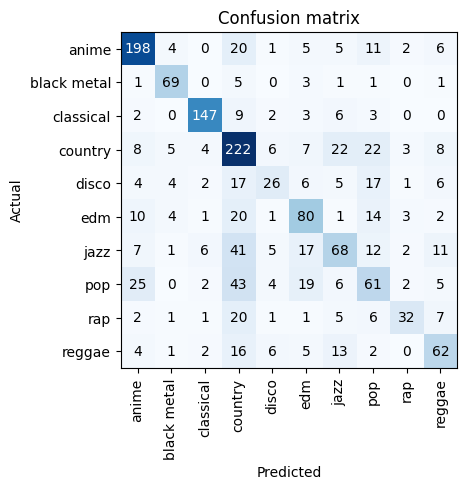

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

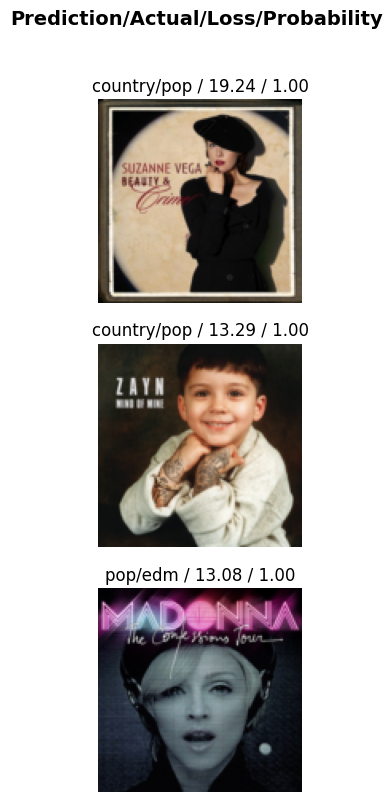

In [ ]:
interp.plot_top_losses(3, nrows=3)

SuggestedLRs(valley=0.0006918309954926372)

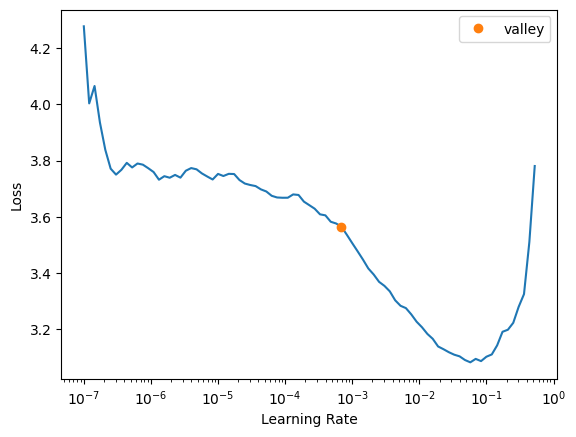

In [12]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.lr_find()

In [13]:
learn = vision_learner(dls, resnet152, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 163MB/s]  


In [14]:
learn.fine_tune(10, base_lr=5e-3)

In [15]:
learn.fit_one_cycle(10)

### Вывод:

- по результату обучения resnet152 показал чуть лучший результат accuracy 0.62, чем resnet50.

***6.Расчет и сравнение метрик.***

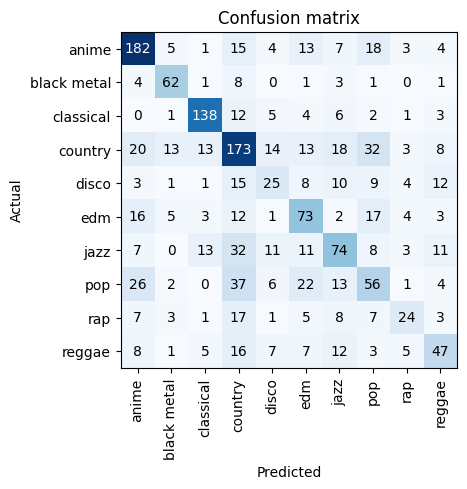

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

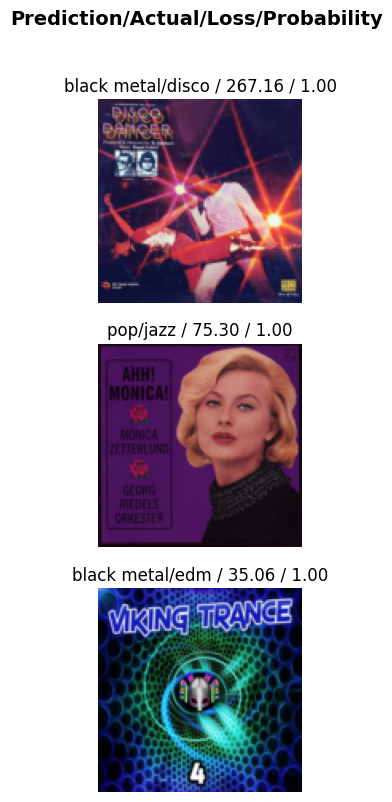

In [17]:
interp.plot_top_losses(3, nrows=3)

SuggestedLRs(valley=0.00019054606673307717)

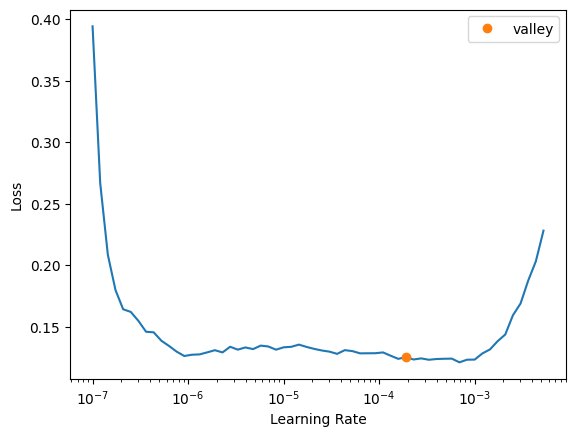

In [18]:
learn.lr_find()

### Вывод:

В результате иследования получены следующие 

resnet50 результат 0.62

resnet152 результат 0.62

EfficientNetB1 результат 0.63


***7.Отчет по исследованию.***

- ознакомление с данными

данные прочитаны,
проверен баланс классов;
выявлен факт принадлежности 4 изображения к разным жанрам;

- предварительная обработка данных

получены эмбеддинги изображений при помощи EfficientNetB1;

- определение целевой метрики

целевой метрикой выбрана accuracy, её проще интерпретировать в данной задаче;

- создание baseline-модели

в качестве baseline принята модель EfficientNetB1;
рассчитаны метрики: accuracy = 0.63;

- пдготовка данных для нейронной сети

для подготовки данных использован загрузчик fastai;

- обучение нейронной сети

обучена нейронная сеть библиотеки fastai с различными комбинациями гиперпараметров;
лучший резальтат: accuracy = 0.62;

- расчет и сравнение метрик

лучший результат оказался у модели fine_tune из библиотеки fastai;

- анализ финальной модели

определены наиболее точно определяемые моделью жанры из представленных: black_metal, classical - 0.87;
самыми сложными для идентификации модели стали жанры: pop, disco, jazz - 0.40;

- общий вывод: 

для выполнения поставленной задачи подходит нейронная сеть fastai,
но для получения более высоких результатов необходим углубленный подбор гиперпараметров.